# 主成分分析 (PCA)

## ライブラリーのインポート

In [63]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from matplotlib.colors import ListedColormap
from sklearn import datasets
from sklearn.decomposition import PCA
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler

## データセットのインポート

In [64]:
# データセットをロード
dataset = datasets.load_wine()

# 一意なクラスラベルを出力
print('特徴量:', dataset.feature_names)
print('クラス:', np.unique(dataset.target))

特徴量: ['alcohol', 'malic_acid', 'ash', 'alcalinity_of_ash', 'magnesium', 'total_phenols', 'flavanoids', 'nonflavanoid_phenols', 'proanthocyanins', 'color_intensity', 'hue', 'od280/od315_of_diluted_wines', 'proline']
クラス: [0 1 2]


## データセットの確認

In [65]:
pd.set_option('display.max_columns', None)
# データセットの特徴量をDataFrameに変換
df = pd.DataFrame(dataset.data, columns=dataset.feature_names)

# 目標変数をDataFrameに追加
df['target'] = dataset.target
df.head()

,alcohol,malic_acid,ash,alcalinity_of_ash,magnesium,total_phenols,flavanoids,nonflavanoid_phenols,proanthocyanins,color_intensity,hue,od280/od315_of_diluted_wines,proline,target
0,14.23,1.71,2.43,15.6,127.0,2.80,3.06,0.28,2.29,5.64,1.04,3.92,1065.0,0
1,13.20,1.78,2.14,11.2,100.0,2.65,2.76,0.26,1.28,4.38,1.05,3.40,1050.0,0
2,13.16,2.36,2.67,18.6,101.0,2.80,3.24,0.30,2.81,5.68,1.03,3.17,1185.0,0
3,14.37,1.95,2.50,16.8,113.0,3.85,3.49,0.24,2.18,7.80,0.86,3.45,1480.0,0
4,13.24,2.59,2.87,21.0,118.0,2.80,2.69,0.39,1.82,4.32,1.04,2.93,735.0,0


## 説明変数と目的変数に分割

In [66]:
#2列目以降のデータをXに、1列目のデータをyに格納
select_features = df.columns[:-1]  # 説明のため最後の列を除くすべての列を選択
X = df.loc[:, select_features].values
y = df.loc[:, 'target'].values

## 訓練データ、テストデータに分割

In [67]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 0)

## 特徴量のスケーリング

In [68]:
sc = StandardScaler()
# 平均と標準偏差を用いて標準化
X_train = sc.fit_transform(X_train)
X_test = sc.transform(X_test)

## 特徴量の重要度を評価

In [69]:
#共分散行列を作成
cov_mat = np.cov(X_train.T)
#固有値と固有ベクトルを計算
eigen_vals, eigen_vecs = np.linalg.eig(cov_mat)


In [70]:
#固有値を合計
tot = sum(eigen_vals)
#分散説明率を計算
var_exp = [(i / tot) for i in sorted(eigen_vals, reverse=True)]
#分散説明率の累積和を取得
cum_var_exp = np.cumsum(var_exp)

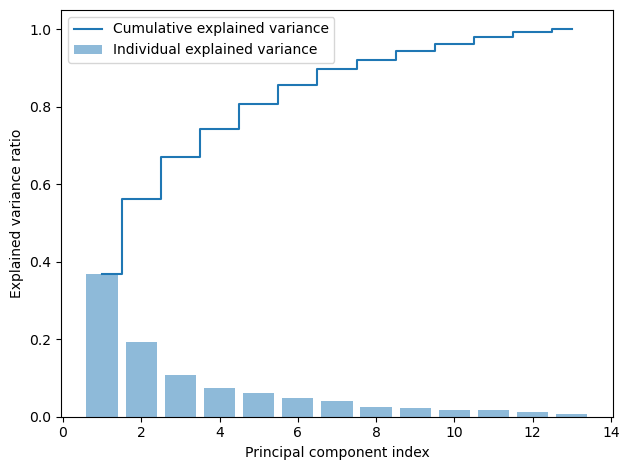

In [71]:
#分散説明率の棒グラフを作成
plt.bar(range(1, len(dataset.feature_names)+1), var_exp, alpha=0.5, align='center',
        label='Individual explained variance')
#分散説明率の累積和の階段グラフを作成
plt.step(range(1, len(dataset.feature_names)+1), cum_var_exp, where='mid',
         label='Cumulative explained variance')
plt.ylabel('Explained variance ratio')
plt.xlabel('Principal component index')
plt.legend(loc='best')
plt.tight_layout()
# plt.savefig('images/05_02.png', dpi=300)
plt.show()

## PCAの適用

今回は、説明のため主成分の個数を2つにしているが、実務では計算効率と分類器の性能のバランスを見ながら、主成分の個数を決定する必要がある。

In [72]:
# 前ステップの分散説明率のグラフより主成分数を指定して、PCAのインスタンスを生成
pca = PCA(n_components = 2)
# 次元削減
X_train = pca.fit_transform(X_train)
X_test = pca.transform(X_test)

## 訓練データによるモデルの学習

In [73]:
# ロジスティック回帰のインスタンスを作成
classifier = LogisticRegression(C=100, random_state=0, solver='lbfgs', multi_class='ovr')
# 訓練データをモデルに適合させる
classifier.fit(X_train, y_train)

LogisticRegression(C=100, multi_class='ovr', random_state=0)

## 新しいデータポイントでの予測

In [74]:
#新しいデータの特徴量
new_data = [[14,1,2,15,127,2,3,1,2,5,1,3,1065]] 
pred_label = classifier.predict(pca.transform(sc.transform(new_data)))[0]
print(f'予測したクラス:{pred_label}({dataset.target_names[pred_label]})')

予測したクラス:0(class_0)


## テストデータで予測

In [75]:
# テストデータで予測を実施
y_pred = classifier.predict(X_test)

## モデルの性能評価

In [76]:
# 正分類のデータ点の個数を表示
print(f'正分類のデータ点: {(y_test == y_pred).sum()}個/{len(y_test)}個' )

# 分類の正解率を表示
print(f'Accuracy(Test): {accuracy_score(y_test, y_pred):.3f}')

正分類のデータ点: 35個/36個
Accuracy(Test): 0.972


## 性能評価の可視化

In [77]:
# 訓練データとテストデータの最小値と最大値を計算
def calculate_bounds(X1, X2):
    X1_min, X1_max = X1.min() - (X1.max()-X1.min())/20, X1.max() + (X1.max()-X1.min())/20
    X2_min, X2_max = X2.min() - (X2.max()-X2.min())/20, X2.max() + (X2.max()-X2.min())/20
    return X1_min, X1_max, X2_min, X2_max

In [89]:
def plot_data(ax, X_set, y_set, X1, X2, Z, colors, kind, classifier):
    cmap = ListedColormap(colors[:len(np.unique(y_set))])
    ax.contourf(X1, X2, Z, alpha=0.3, cmap=cmap)
    for idx, feature in enumerate(np.unique(y_set)):
        ax.scatter(x=X_set[y_set == feature, 0], 
                   y=X_set[y_set == feature, 1],
                   alpha=0.5, 
                   color=colors[idx],
                   marker='o', 
                   label=dataset.target_names[feature], 
                   edgecolor='black')
    ax.set_xlabel('PC1')
    ax.set_ylabel('PC2')
    ax.set_title(f'{type(classifier).__name__}_{type(pca).__name__} ({kind})')
    ax.legend(loc='best')

In [90]:
def plot_decision_regions(X_train, X_test, y_train, y_test, classifier):
    # マーカーとカラーマップの準備
    colors = ('red', 'blue', 'green')
    
    # スケーリング前の元のデータに変換
    X_train_set, y_train_set = X_train, y_train
    X_test_set, y_test_set = X_test, y_test
    
    # 訓練データとテストデータの範囲を統一
    X_combined = np.vstack((X_train_set, X_test_set))
    X1_min, X1_max, X2_min, X2_max = calculate_bounds(X_combined[:, 0], X_combined[:, 1])
    
    # グリッドポイントの生成
    X1, X2 = np.meshgrid(np.arange(X1_min, X1_max, step=(X1_max - X1_min) / 1000),
                         np.arange(X2_min, X2_max, step=(X2_max - X2_min) / 1000))
    # 各特徴を1次元配列に変換して予測を実行
    Z = classifier.predict(np.array([X1.ravel(), X2.ravel()]).T)
    # 予測結果を元のグリッドポイントのデータサイズに変換
    Z = Z.reshape(X1.shape)
    
    fig, ax = plt.subplots(1, 2, figsize=(8, 4))
    
    # 訓練データとテストデータのプロット
    plot_data(ax[0], X_train_set, y_train_set, X1, X2, Z, colors, "Training set", classifier)
    plot_data(ax[1], X_test_set, y_test_set, X1, X2, Z, colors, "Test set", classifier)
    
    plt.tight_layout()
    plt.show()

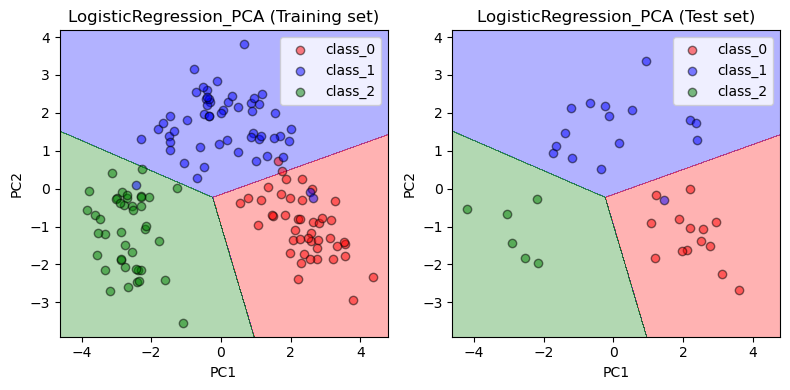

In [91]:
# 決定境界のプロット
if pca.n_components_ == 2:
    plot_decision_regions(X_train, X_test, y_train, y_test, classifier)
else:
    print("特徴量が2個の場合のみプロットが可能です。選択された特徴量の数:", len(select_features))